# Nonlinear and Conic Optimization

In this part of the session, we discuss methods for modelling and solving conic optimization problems of the form

\begin{align}
\min \ \langle c, x\rangle\\
\text{s.t.} \ A x=b,\\
x \in \mathcal{K},
\end{align}
where $\mathcal{K}$ is a convex cone. For instance, if we were considering an LP then $\mathcal{K}=\mathbb{R}^n_+$, or if we were considering a semidefinite optimization problem then $\mathcal{K}=S^n_+$, the set of positive semidefinite matrices.

This optimization problem is actually very general: it models linear, convex quadratic, semidefinite and exponential optimization problems among others. The main advantage of writing problems in this form is that we can solve conic optimization problems very fast using interior point methods.

We won't dive into the theory of conic optimization here (there's enough theory to fill up several classes!), but great resources on conic optimization include:
* Convex optimization: https://web.stanford.edu/~boyd/cvxbook/. Very readable.
* Lectures on modern convex optimization: https://www2.isye.gatech.edu/~nemirovs/Lect_ModConvOpt.pdf. Comprehensive, but can go off the deep end.
* The Mosek modelling cookbook: Very readable and compact https://docs.mosek.com/MOSEKModelingCookbook-letter.pdf.

# Support Vector Machine Optimization using Mosek.

Our running example for this part of the session is support vector machine optimization, to keep things concrete and illustrate the basic use of JuMP.jl for conic problems.

Support Vector Machines are a popular model in machine learning for classification. The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

We are going to build our own custom svm solver, so that we can include constraints which off-the-shelf SVM solvers can't handle. Because we are using JuMP, we should expect that our solver will be slower but more flexible than state-of-the-art SVM solvers such as scikit-learn.

Note that while this problem has a quadratic term in the objective, JuMP will actually convert it to a conic quadratic objective automatically!

Let's load the packages we will use to write our custom SVM solver, and define a function which generates some random test data in 2d.

In [30]:
using JuMP, Mosek, MosekTools, Distributions, Plots, LinearAlgebra, Suppressor, Time
gr(); # In Ryan's view, the nicest plotting backend for generating plots in Julia.

ArgumentError: ArgumentError: Package Time not found in current path:
- Run `import Pkg; Pkg.add("Time")` to install the Time package.


In [7]:
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-1.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's visualize our synthetic data.

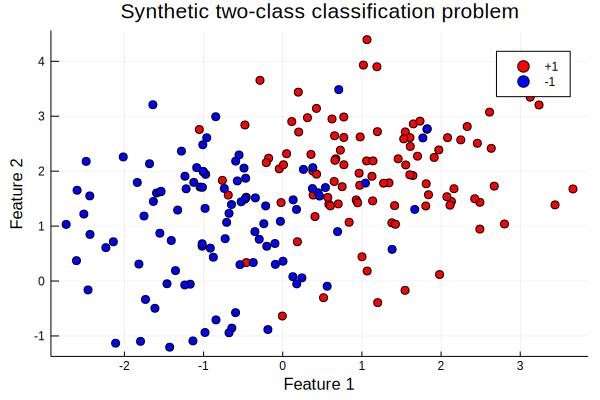

In [11]:
x,y = gen_data(100)
scatter(x[1,1:100], x[2,1:100], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,101:200], x[2,101:200], c=:blue, label="-1")

In [28]:
γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(with_optimizer(Mosek.Optimizer)) 
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)

    #########################################################
    # You need to fill this bit in.
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w.-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    #########################################################
    
    @suppress optimize!(svmModel)
    return value.(w), value.(b)
end

svm (generic function with 1 method)

In [31]:
N = 500
x,y = gen_data(N)

@time w,b = svm(x,y)

  0.189055 seconds (195.10 k allocations: 13.266 MiB, 27.68% gc time)


([1.4585880035210748, 0.6883245362626595], 1.0509476756063736)

Let's visualize this SVM.

In [37]:

# y1 = (-1+b-w[1]*xmin)/w[2]
# y2 = (-1+b-w[1]*xmax)/w[2]
# plot([xmin,xmax], [y1,y2], "k-");
# y1 = (b-w[1]*xmin)/w[2]
# y2 = (b-w[1]*xmax)/w[2]
# ylim(ymin,ymax)
# plot([xmin,xmax], [y1,y2], "k-");

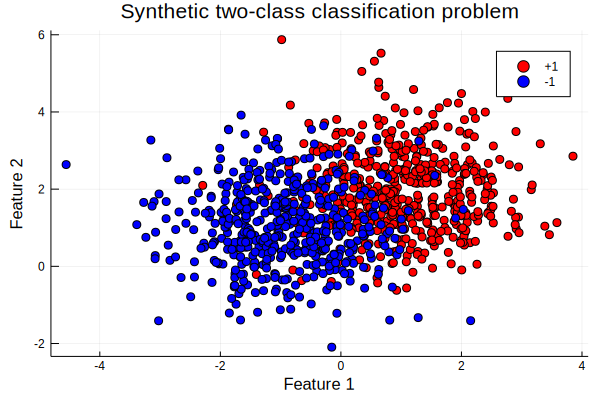

In [35]:
scatter(x[1,1:N], x[2,1:N], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,(N+1):2*N], x[2,(N+1):2*N], c=:blue, label="-1")


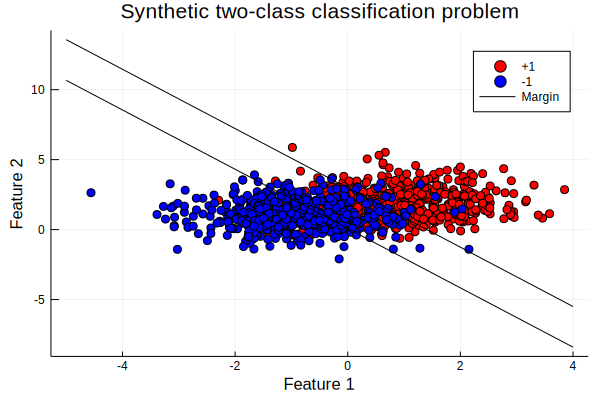

In [53]:
xmin, xmax = [-5,4]
ymin, ymax = [-2,6]
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
scatter(x[1,1:N], x[2,1:N], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,(N+1):2*N], x[2,(N+1):2*N], c=:blue, label="-1")
plot!([xmin,xmax], [y1,y2], c=:black, label="Margin")
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot!([xmin,xmax], [y1,y2], c=:black, label="")

# Binary Quadratic Optimization

In [54]:
# Part 2: todo.